In [36]:
# Importamos las librería necesarias para la manipulación y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

# Configurar el nivel de registro de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = todos los mensajes, 1 = advertencias, 2 = errores, 3 = críticos

# Librerías para el procesamiento del modelo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Librería para la prueba de  hiperparámetros
import keras_tuner as kt

# Librerías del modelo de red convolucional CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [37]:
# Leemos los csv con los datos de entrenamiento
ruta_train = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_train.csv"
df = pd.read_csv(ruta_train, sep=';', decimal='.')

# Leemos los csv con los datos de prueba
ruta_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_prueba.csv"
df_prueba = pd.read_csv(ruta_prueba, sep=';', decimal='.')

In [38]:
# Mostramos los primeros datos
df.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2023-01-01 00:00:00,2023,1,1,0,0,6,192.00,1.16,6.93,69.69,7.6,0.0,0.0
1,2023-01-01 00:15:00,2023,1,1,0,15,6,164.73,0.75,5.65,65.35,7.6,0.0,0.0
2,2023-01-01 00:30:00,2023,1,1,0,30,6,635.38,1.58,20.05,74.82,7.6,0.0,0.0
3,2023-01-01 00:45:00,2023,1,1,0,45,6,1234.29,5.05,38.98,72.51,7.6,0.0,0.0
4,2023-01-01 01:00:00,2023,1,1,1,0,6,1701.24,8.20,52.78,68.58,7.5,0.0,0.0


In [39]:
# Mostramos los primeros datos
df_prueba.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2024-01-01 00:00:00,2024,1,1,0,0,0,198.02,0.78,6.56,69.64,6.5,0.0,1.0
1,2024-01-01 00:15:00,2024,1,1,0,15,0,178.85,0.44,5.89,64.53,6.5,0.0,1.0
2,2024-01-01 00:30:00,2024,1,1,0,30,0,666.07,1.84,21.56,74.09,6.5,0.0,1.0
3,2024-01-01 00:45:00,2024,1,1,0,45,0,1269.45,5.25,40.07,71.13,6.5,0.0,1.0
4,2024-01-01 01:00:00,2024,1,1,1,0,0,1691.75,7.75,52.76,68.56,6.3,0.0,1.0


In [40]:
# Nos aseguramos que la columna 'fecha' esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_prueba['fecha'] = pd.to_datetime(df_prueba['fecha'])

# Seleccionamos las columnas relevantes para el modelo
feature_cols = ['intensidad', 'ocupacion', 'carga', 'vmed', 'HORA', 'DIA_SEMANA', 'TEMPERATURA', 'FESTIVO']
df_encoded = df[feature_cols]
df_encoded_prueba = df_prueba[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])

# Creamos las secuencias para el modelo
window_size = 100  # 1 día (96 intervalos de 15 minutos)
n_features = len(feature_cols)

forecast_steps = 4  # Número de pasos a predecir
X = []
y = []

for i in range(window_size, len(df) - forecast_steps + 1):
    X.append(df_encoded.iloc[i-window_size:i].values)
    y.append(df_encoded.iloc[i:i+forecast_steps]['intensidad'].values)

X = np.array(X)
y = np.array(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_prueba = []
y_prueba = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(df_prueba) - forecast_steps + 1):
    X_prueba.append(df_encoded_prueba.iloc[i-window_size:i].values)
    y_prueba.append(df_encoded_prueba.iloc[i:i+forecast_steps]['intensidad'].values)

X_prueba = np.array(X_prueba)
y_prueba = np.array(y_prueba)

/tmp/ipykernel_195963/3652465113.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
/tmp/ipykernel_195963/3652465113.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])


In [41]:
# Verificar si TensorFlow detecta la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detectadas:", gpus)
    try:
        # Configurar TensorFlow para usar la GPU de manera eficiente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("La GPU está configurada para su uso.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se detectaron GPUs. El entrenamiento se realizará en la CPU.")

GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
La GPU está configurada para su uso.


In [42]:
# Función para construir el modelo CNN con hiperparámetros
def build_tuned_cnn(hp):
    
    # Indicamos que el modelo será secuencial, es decir, una secuencia de diferentes capas
    model = Sequential()
    
    # Primera capa Convolucional
    model.add(Conv1D(
        # El número de filtros variará entre 32 y 128 en pasos de 32
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        # El tamaño del kernel varia entre 3 y 5
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        # Función de activación Relu
        activation='relu',
        # Forma de entrada definida por los datos de entrenamiento (X_train)
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    # Capa MaxPooling1D que reduce la dimensionalidad a 2
    model.add(MaxPooling1D(pool_size=2))
    # Capa Dropout que desactivará neuronas entre 0.2 y 0.5
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Segunda capa Convolucional
    model.add(Conv1D(
        # El número de filtros variará entre 32 y 128 en pasos de 32
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        # El tamaño del kernel varia entre 3 y 5
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        # Función de activación Relu
        activation='relu'
    ))
    # Capa MaxPooling1D que reduce la dimensionalidad a 2
    model.add(MaxPooling1D(pool_size=2))
    # Capa Dropout que desactivará neuronas entre 0.2 y 0.5
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Aplanar las características para obtener un vector unidimensional
    model.add(Flatten())
    
    # Capa densa
    model.add(Dense(
        # Ajuste de unidades entre 32 y 128 en pasos de 32
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        # Función de activación Relu
        activation='relu'
    ))
    # Capa Dropout que desactivará neuronas entre 0.2 y 0.5
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Capa densa de salida
    model.add(Dense(forecast_steps, activation='linear'))  # Salida de 2 pasos

    # Compilar el modelo
    model.compile(
        # Optimizador Adam
        optimizer='adam',
        # Función de pérdida MSE (error cuadrático medio)
        loss='mse',
        # Métrica MAE error absoluto medio
        metrics=['mae']
    )
    
    return model

# Definimos el tuner para buscar hiperparámetros
tuner = kt.RandomSearch(
    # Función que construye el modelo
    build_tuned_cnn,
    # Indicamos que queremos minimizar la pérdida de validación
    objective='val_loss',
    # Número de combinaciones a probar
    max_trials=10,
    # Número de ejecuciones por cada combinación de hiperparámetros
    executions_per_trial=1,
    # Ruta en la que se guardan los resultados para poder recuperarlos posteriormente
    directory='cnn_hyperparameter_tuning',
    project_name='cnn_tuning_todas_estaciones'
)

# Detenemos el entrenamiento si no se observa mejora de la pérdidoa de validación tras 5 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Reducimos la tasa de aprendizaje a la mitad si no se observa mejora de la pérdidoa de validación tras 3 épocas consecutivas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Realizamos la búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Nos quedamos con los hiperparámetros que mejor resultado han ofrecido
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros:")
print(f" - Filtros primera capa: {best_hps.get('filters_1')}")
print(f" - Tamaño kernel primera capa: {best_hps.get('kernel_size_1')}")
print(f" - Dropout primera capa: {best_hps.get('dropout_1')}")
print(f" - Filtros segunda capa: {best_hps.get('filters_2')}")
print(f" - Tamaño kernel segunda capa: {best_hps.get('kernel_size_2')}")
print(f" - Dropout segunda capa: {best_hps.get('dropout_2')}")
print(f" - Unidades densas: {best_hps.get('dense_units')}")
print(f" - Dropout capa densa: {best_hps.get('dense_dropout')}")

Reloading Tuner from cnn_hyperparameter_tuning/cnn_tuning_todas_estaciones/tuner0.json
Mejores hiperparámetros:
 - Filtros primera capa: 128
 - Tamaño kernel primera capa: 3
 - Dropout primera capa: 0.2
 - Filtros segunda capa: 64
 - Tamaño kernel segunda capa: 5
 - Dropout segunda capa: 0.30000000000000004
 - Unidades densas: 96
 - Dropout capa densa: 0.2


In [43]:
# Nos quedamos con el mejor modelo y los mejores hiperparámetros encontrados
best_model = tuner.hypermodel.build(best_hps)

# Resumen del modelo
best_model.summary()

/home/miguel/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 98, 128)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │       135,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,876 (702.64 KB)

 Trainable params: 179,876 (702.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Entrenamos el modelo
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1342 - mae: 0.2764 - val_loss: 0.0516 - val_mae: 0.1880 - learning_rate: 0.0010
Epoch 2/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0530 - mae: 0.1797 - val_loss: 0.0324 - val_mae: 0.1434 - learning_rate: 0.0010
Epoch 3/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0441 - mae: 0.1641 - val_loss: 0.0265 - val_mae: 0.1288 - learning_rate: 0.0010
Epoch 4/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0397 - mae: 0.1558 - val_loss: 0.0220 - val_mae: 0.1156 - learning_rate: 0.0010
Epoch 5/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0373 - mae: 0.1511 - val_loss: 0.0229 - val_mae: 0.1174 - learning_rate: 0.0010
Epoch 6/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0352 - mae: 0.1461 - val_loss: 0.0251 - val_mae: 0.1247 - learning_rate: 0.0010
Epoch 7/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0344 - mae: 0.1450 - val_loss: 0.0241 - val_mae: 0.1258 - learning_rate: 0.0010
Epoch 

In [45]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_test)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_test), len(feature_cols))), columns=feature_cols)

# Paso 1 (15 minutos)
df_reconstructed['intensidad'] = y_test[:, 0]
y_test_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_test[:, 1]
y_test_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_test[:, 2]
y_test_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_test[:, 3]
y_test_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_test[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_test[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_test[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_test[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_test[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_test[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_test[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Paso 1 - MAE: 0.0728449968664773, MSE: 0.009539354541816956, RMSE: 0.09766961933895799, R-squared: 0.9905316484395271
Paso 2 - MAE: 0.07309667264104261, MSE: 0.009671598725605017, RMSE: 0.09834428669528808, R-squared: 0.990380850101998
Paso 3 - MAE: 0.07271976490117699, MSE: 0.009867553516046736, RMSE: 0.09933556017885406, R-squared: 0.9901865552660426
Paso 4 - MAE: 0.07501527912961586, MSE: 0.010456013494385808, RMSE: 0.10225465023355079, R-squared: 0.9895934461604832


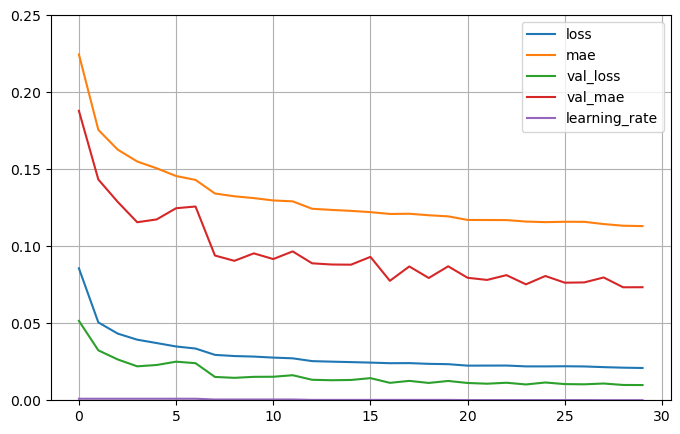

In [46]:
# Mostramos la evolución de las métricas a lo largo del entrenamiento
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.25)
plt.show()

#### Gráficas

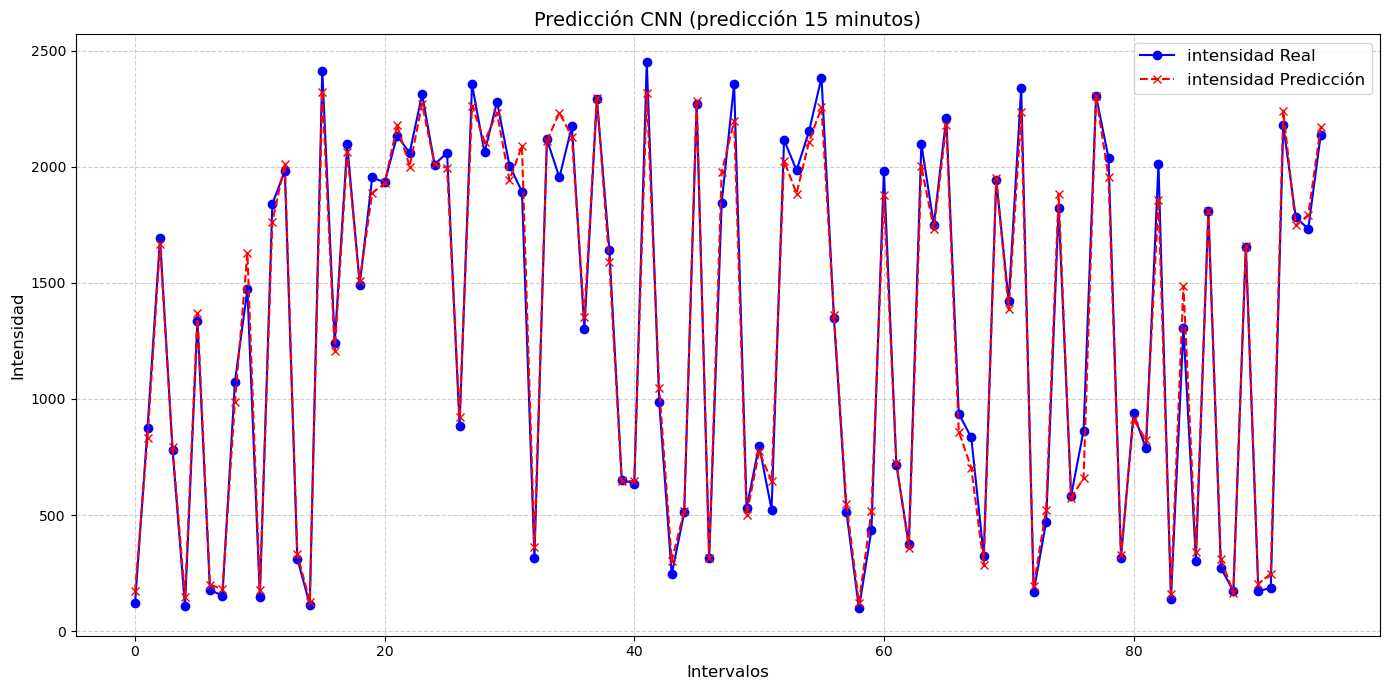

In [47]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


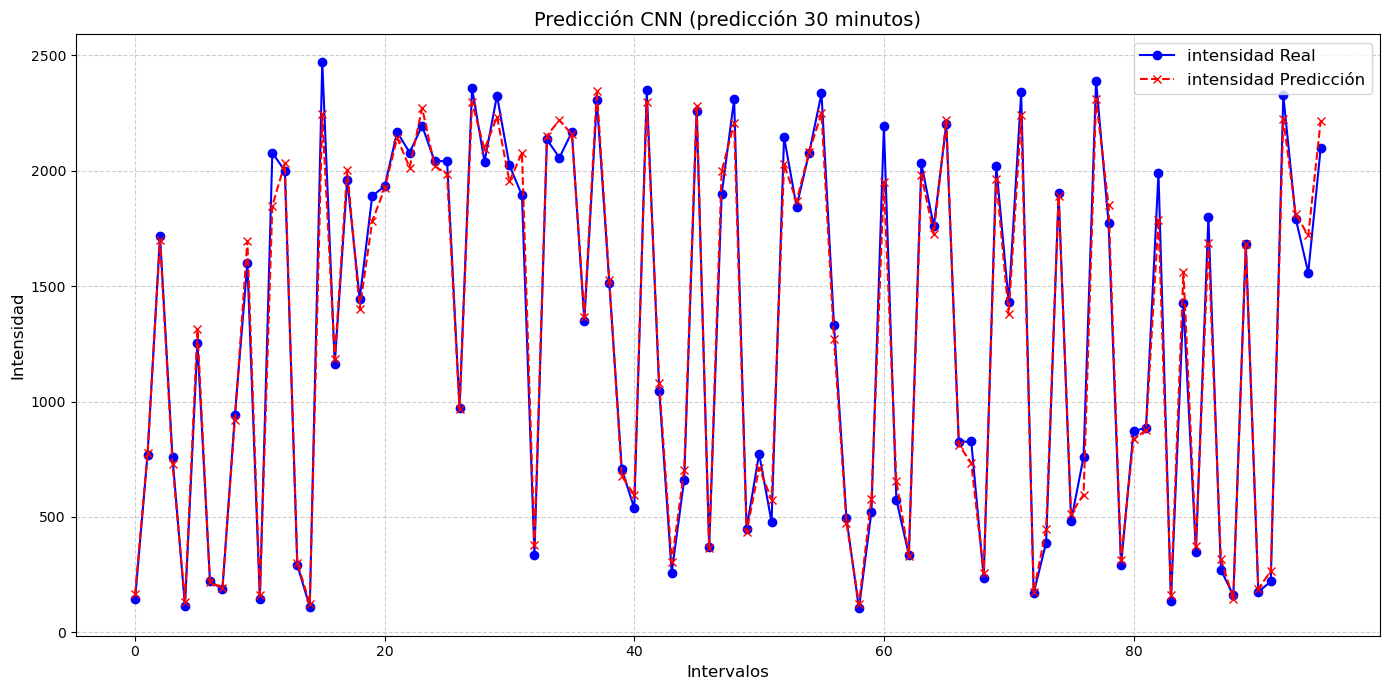

In [48]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

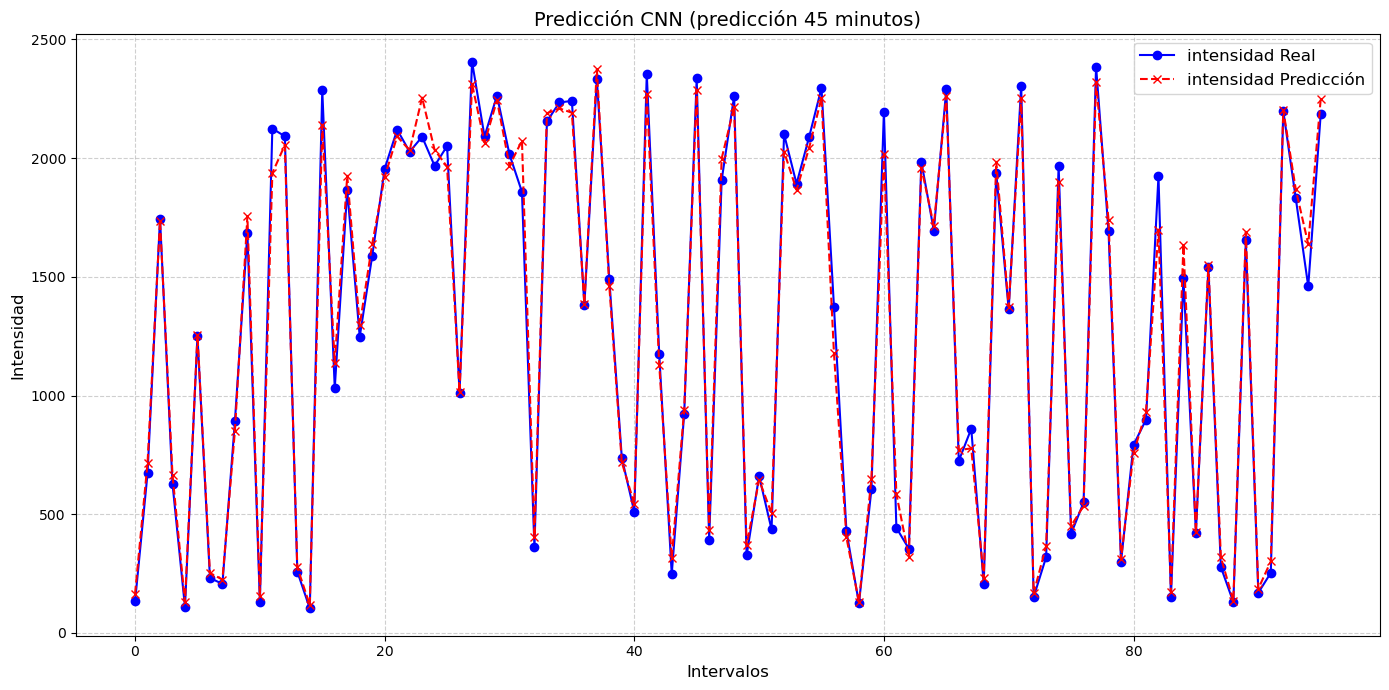

In [49]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

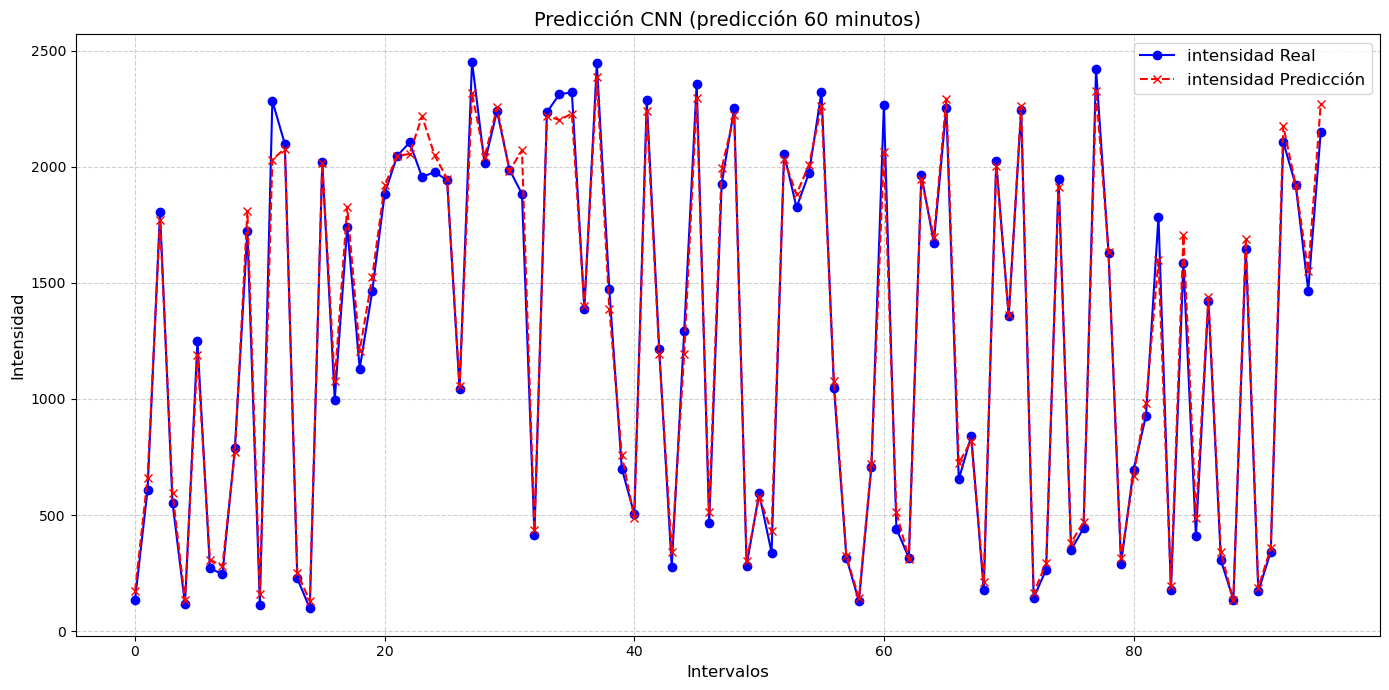

In [50]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Guardamos el modelo

In [51]:
# Ruta para guardar el modelo
ruta_modelo = '/mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_model_CNN.pkl'

# Guardamos el modelo
joblib.dump(best_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")

Modelo guardado en /mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_model_CNN.pkl


## Validación con un conjunto de datos no visto por el modelo

In [52]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_prueba)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_prueba), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_prueba[:, 0]
y_prueba_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 1]
y_prueba_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 2]
y_prueba_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 3]
y_prueba_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_prueba[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_prueba[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_prueba[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_prueba[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_prueba[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_prueba[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_prueba[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_prueba[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_prueba[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_prueba[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_prueba[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_prueba[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Paso 1 - MAE: 0.0789980145212544, MSE: 0.011474887916317181, RMSE: 0.10712090326503591, R-squared: 0.9885556629424851
Paso 2 - MAE: 0.07870968777527762, MSE: 0.011536360657353235, RMSE: 0.10740745159137347, R-squared: 0.988491847570977
Paso 3 - MAE: 0.07853465433857948, MSE: 0.01165603897001276, RMSE: 0.10796313708860428, R-squared: 0.9883696853090256
Paso 4 - MAE: 0.07870871431490456, MSE: 0.011889276102771115, RMSE: 0.10903795716525101, R-squared: 0.9881341575853982


#### Gráficas

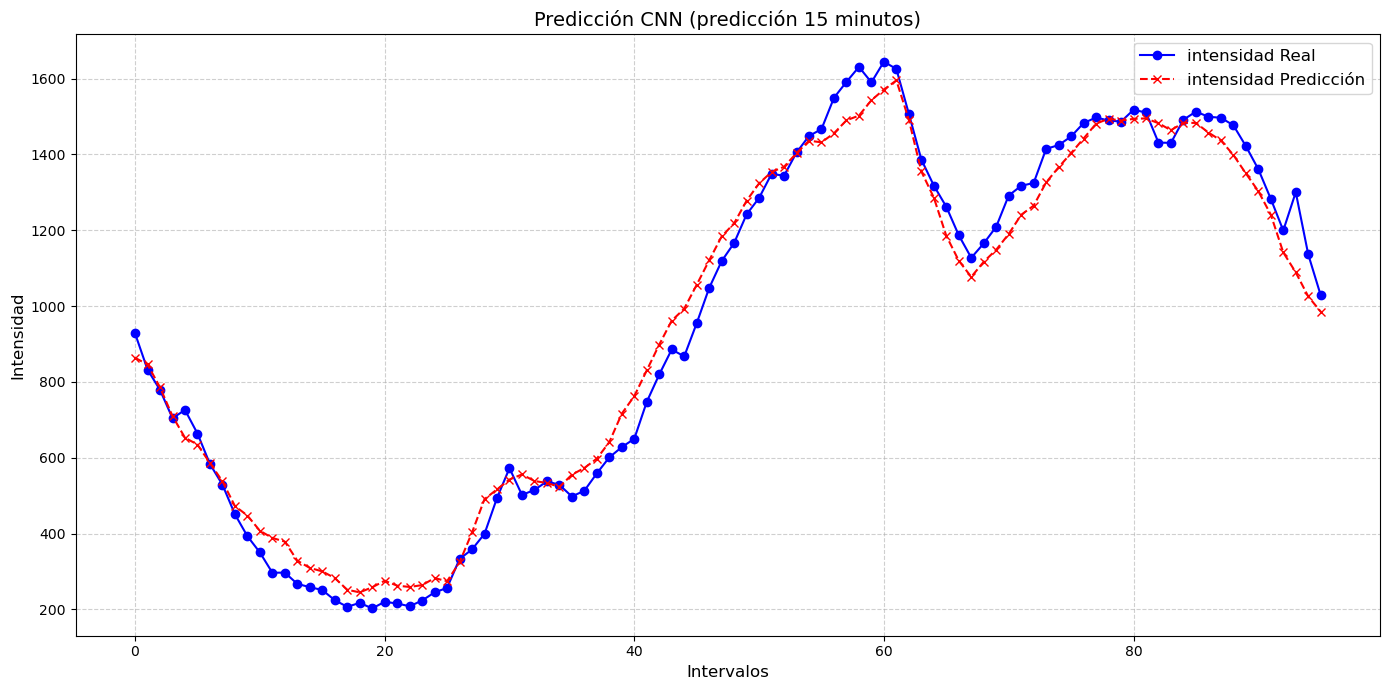

In [53]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

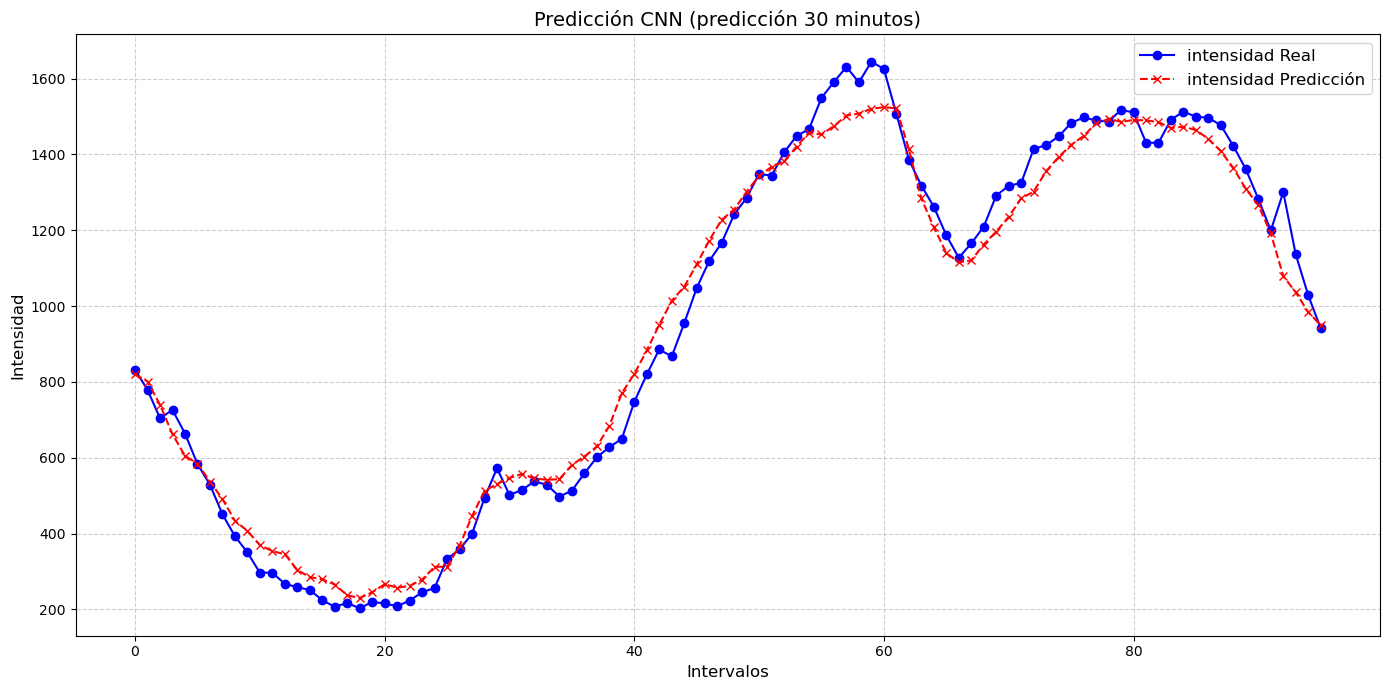

In [54]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

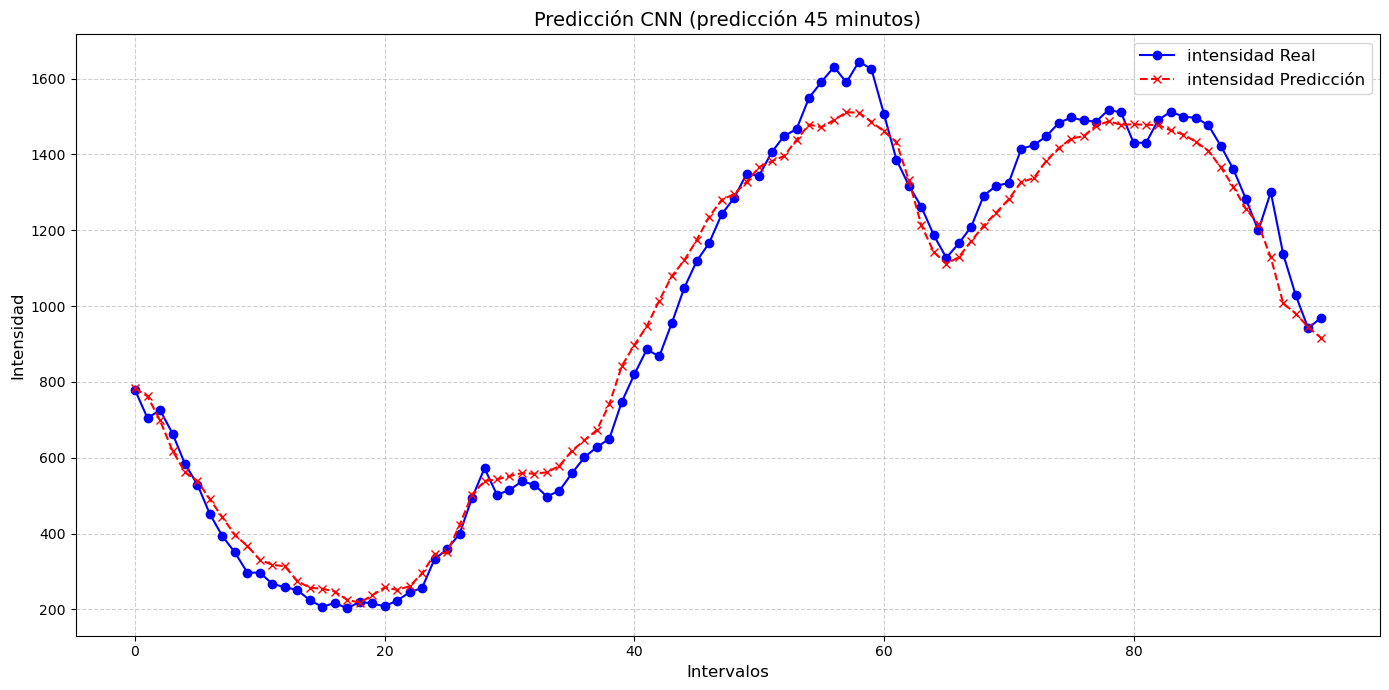

In [55]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

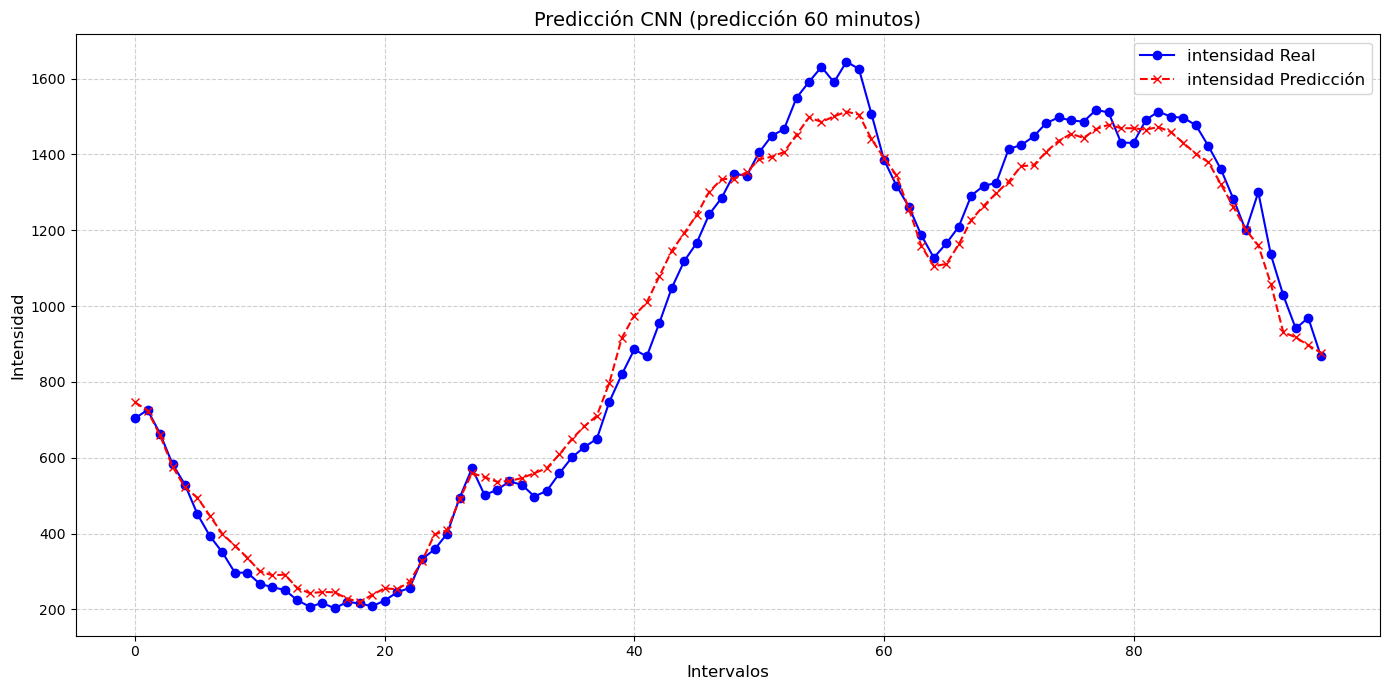

In [56]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Prueba una única estación  
Probamos el modelo sobre la estación 3490 (Km 10.8 de la M-30).

In [68]:
# Leemos los csv con los datos de entrenamiento
ruta_estacion_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_estacion = pd.read_csv(ruta_estacion_prueba, sep=';', decimal='.')

# Creamos el conjunto con los datos de la estación 3490
datos_3490 = df_estacion[df_estacion['id'] == 3490]

In [70]:
# Preparamos los datos de la estación
# Nos aseguramos que la columna 'fecha' esté en formato datetime
datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])

# Seleccionamos las columnas relevantes para el modelo
df_encoded_3490 = datos_3490[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


X_3490 = []
y_3490 = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(datos_3490) - forecast_steps + 1):
    X_3490.append(df_encoded_3490.iloc[i-window_size:i].values)
    y_3490.append(df_encoded_3490.iloc[i:i+forecast_steps]['intensidad'].values)

X_3490 = np.array(X_3490)
y_3490 = np.array(y_3490)

/tmp/ipykernel_195963/942581670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])
/tmp/ipykernel_195963/942581670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


In [71]:
# Calcular predicciones del conjunto de validación
y_pred = best_model.predict(X_3490)  # Salida de forma (n_samples, forecast_steps)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_3490), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_3490[:, 0]
y_3490_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_3490[:, 1]
y_3490_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_3490[:, 2]
y_3490_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_3490[:, 3]
y_3490_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_3490[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_3490[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_3490[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_3490[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_3490[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_3490[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_3490[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_3490[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_3490[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_3490[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_3490[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_3490[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Paso 1 - MAE: 0.22451956918928048, MSE: 0.11736819616688862, RMSE: 0.3425904204248692, R-squared: 0.8830202519134176
Paso 2 - MAE: 0.23017628532626505, MSE: 0.12416004324988575, RMSE: 0.35236351009984807, R-squared: 0.8762238469405955
Paso 3 - MAE: 0.2336041844245097, MSE: 0.12895284256815395, RMSE: 0.3591000453469116, R-squared: 0.8714142311045374
Paso 4 - MAE: 0.2374685470619906, MSE: 0.13367523310842178, RMSE: 0.36561623747916583, R-squared: 0.8666731332009815


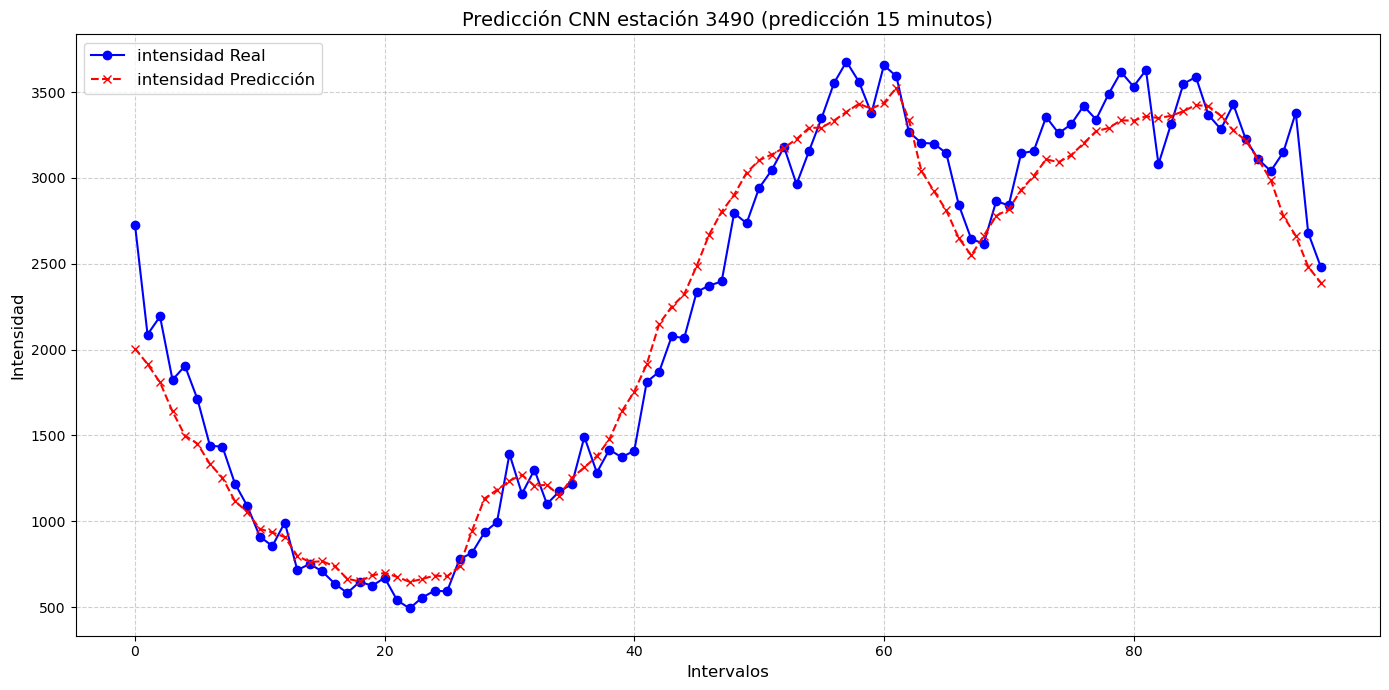

In [72]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN estación 3490 (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

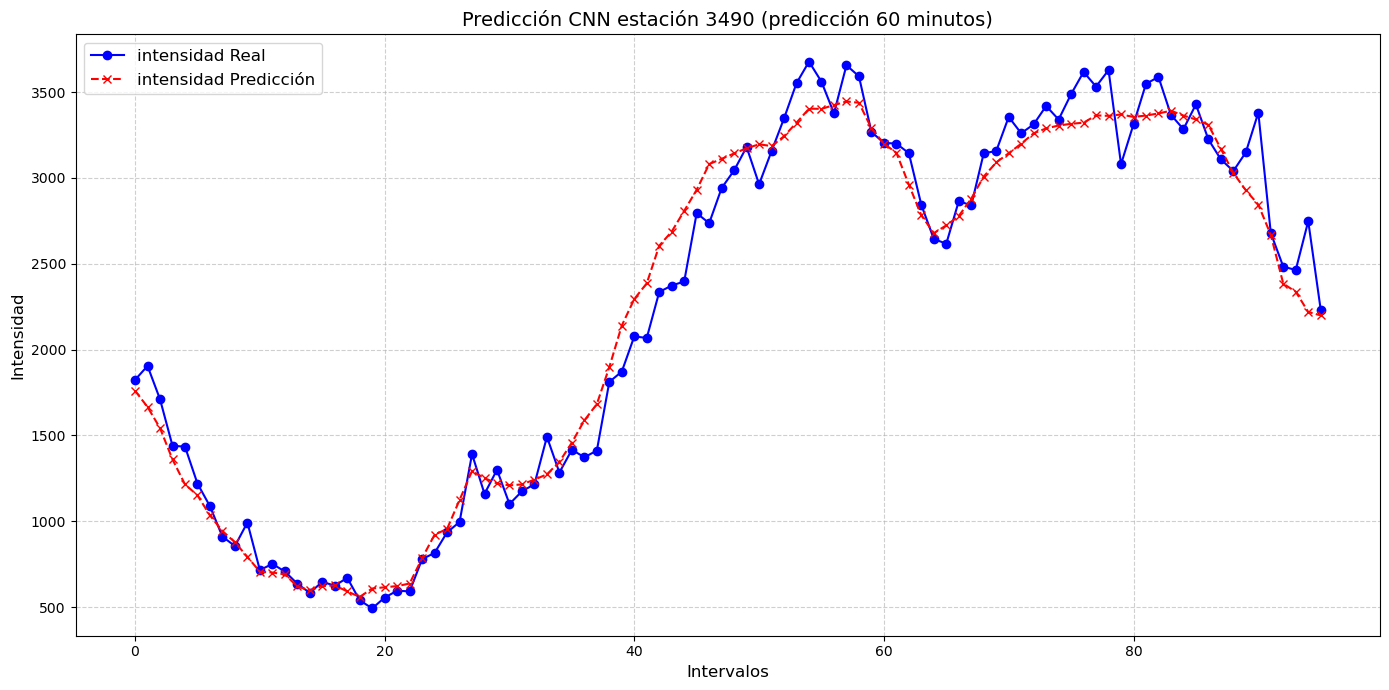

In [73]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción CNN estación 3490 (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()